In [15]:
# Install libraries (run in a Colab cell)
!pip install pandas numpy matplotlib seaborn scikit-learn prophet shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For advanced models and feature importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prophet for time series forecasting
from prophet import Prophet




In [16]:
# Load dataset (update path if file is in your Drive)
df = pd.read_csv('GlobalWeatherRepository.csv')
df.head()


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1.715849e+09,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1.0,1.0,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55.0
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1.715849e+09,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1.0,1.0,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55.0
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1.715849e+09,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1.0,1.0,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55.0
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1.715849e+09,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1.0,1.0,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55.0
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1.715849e+09,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5.0,10.0,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55.0


In [17]:
# Check missing values
df.isnull().sum()

# Fill missing: median for numeric, mode for categorical
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=[object]).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Outlier treatment: cap values outside 1.5*IQR
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = np.clip(df[col], lower, upper)

# Normalize numerical features
scaler = MinMaxScaler()
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = scaler.fit_transform(df[num_cols])


/tmp/ipython-input-992844340.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-992844340.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

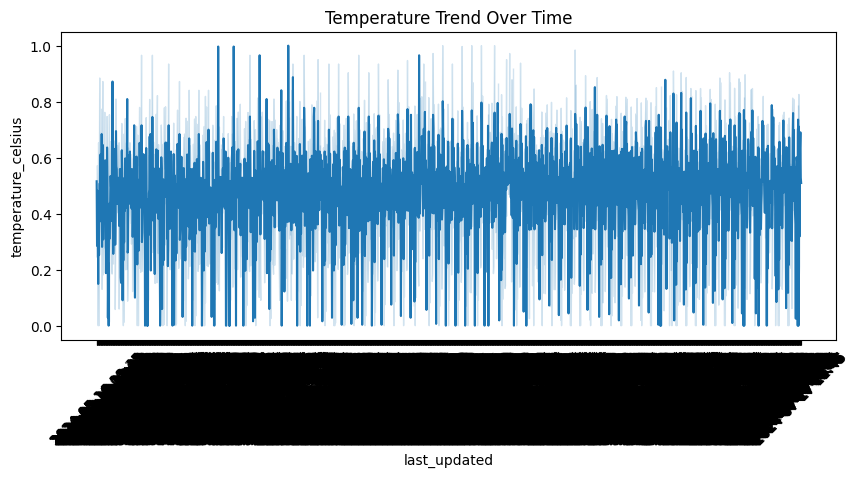

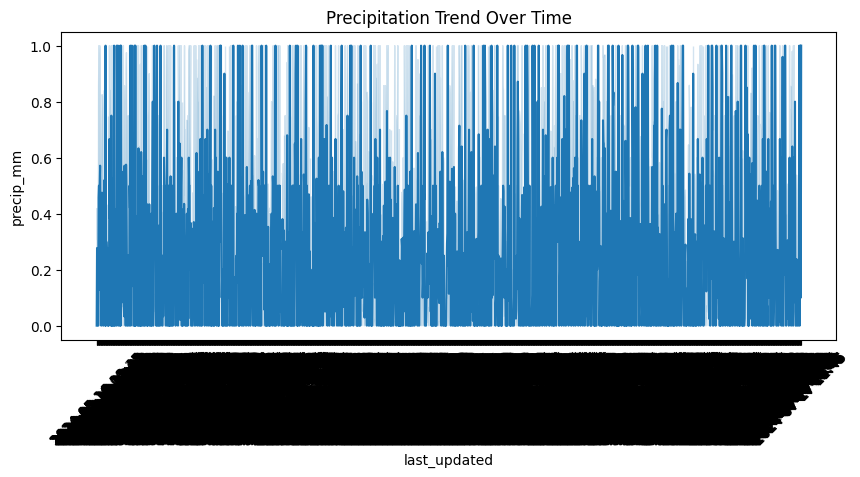

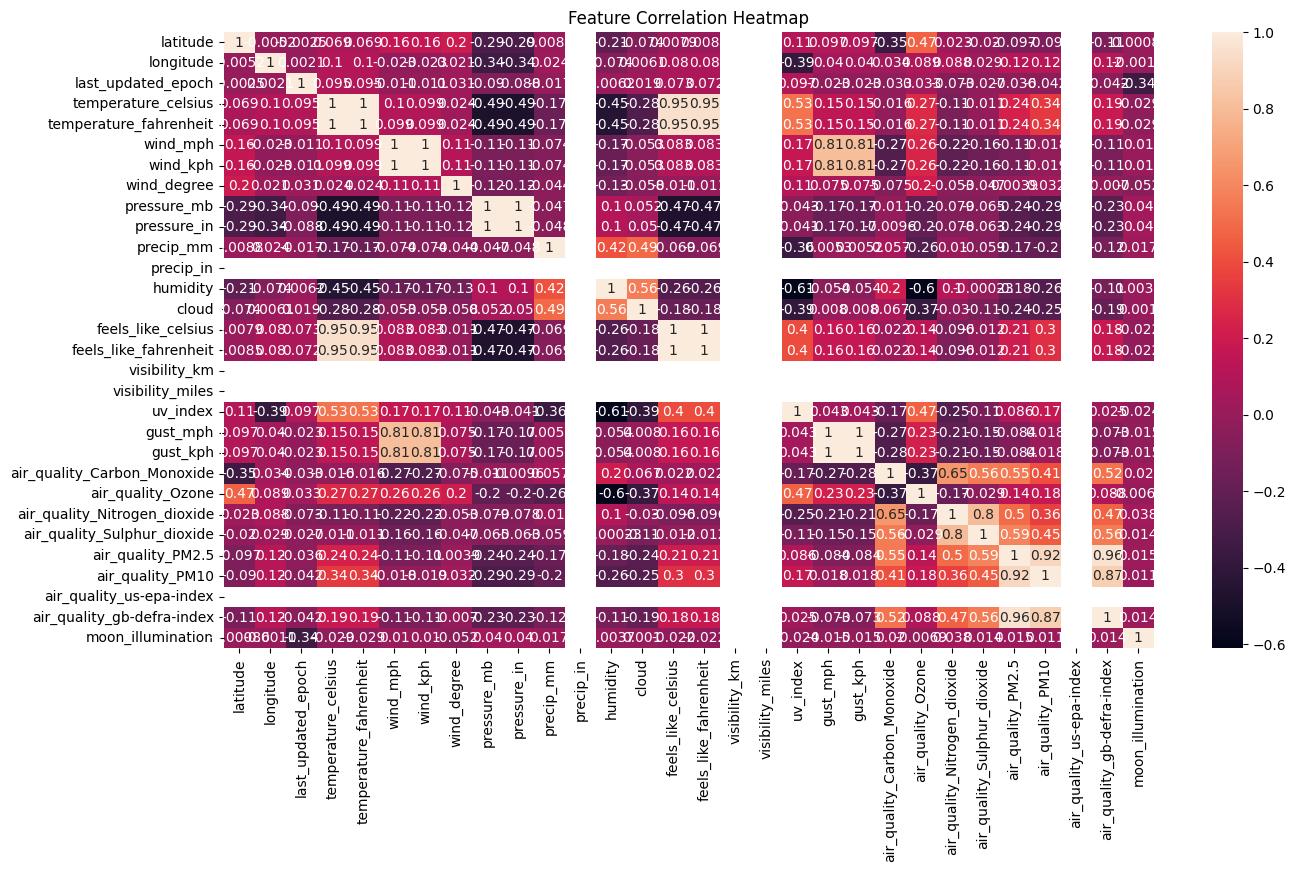

In [20]:
# Temperature trends visualization
plt.figure(figsize=(10,4))
sns.lineplot(x='last_updated', y='temperature_celsius', data=df)
plt.title('Temperature Trend Over Time')
plt.xticks(rotation=45)
plt.show()

# Precipitation trends
plt.figure(figsize=(10,4))
sns.lineplot(x='last_updated', y='precip_mm', data=df)
plt.title('Precipitation Trend Over Time')
plt.xticks(rotation=45)
plt.show()

# Heatmap for feature correlation
plt.figure(figsize=(15,8))
sns.heatmap(df[num_cols].corr(), annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshkt6_zt/lonc5ejh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpshkt6_zt/sdk22a6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99196', 'data', 'file=/tmp/tmpshkt6_zt/lonc5ejh.json', 'init=/tmp/tmpshkt6_zt/sdk22a6o.json', 'output', 'file=/tmp/tmpshkt6_zt/prophet_modela0jwdm7o/prophet_model-20250812045234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:52:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


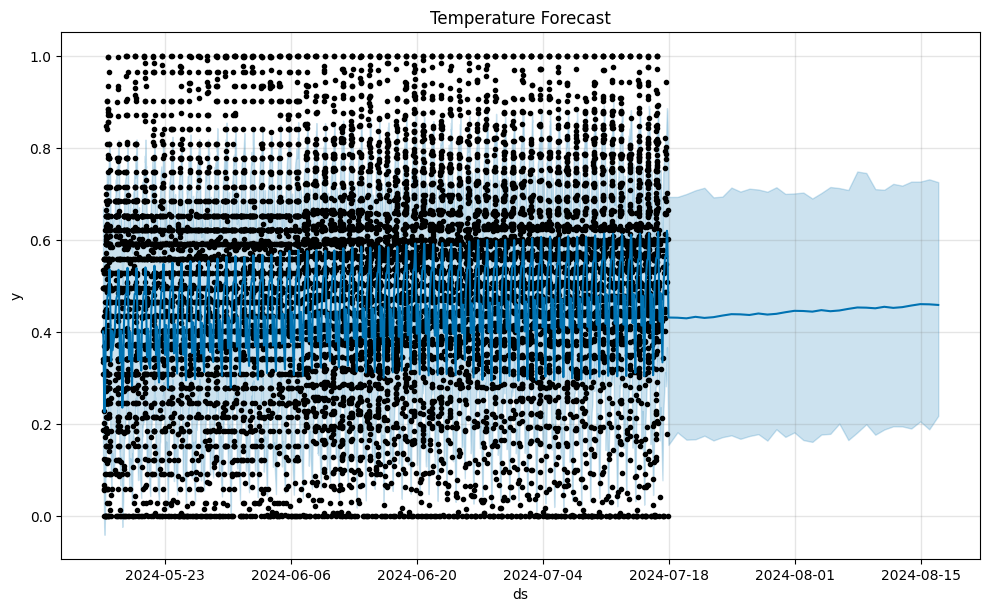

MAE: 0.18188468065486227
RMSE: 0.2259303613086587


In [21]:
# Time Series Forecasting (using Prophet)
weather = df[['last_updated', 'temperature_celsius']].copy()
weather.rename(columns={'last_updated':'ds', 'temperature_celsius':'y'}, inplace=True)
weather['ds'] = pd.to_datetime(weather['ds'])

model = Prophet()
model.fit(weather)

future = model.make_future_dataframe(periods=30)  # forecast next 30 days
forecast = model.predict(future)

model.plot(forecast)
plt.title('Temperature Forecast')
plt.show()

# Evaluation (split actual vs predicted if you have test data)
actual = weather['y'].tail(30)
pred = forecast['yhat'].tail(30)
print("MAE:", mean_absolute_error(actual, pred))
print("RMSE:", np.sqrt(mean_squared_error(actual, pred)))


In [22]:
# IsolationForest on temperature
iso = IsolationForest(contamination=0.01)
df['anomaly_flag'] = iso.fit_predict(df[['temperature_celsius']])
anomalies = df[df['anomaly_flag'] == -1]
print("Anomalies detected:", len(anomalies))


Anomalies detected: 105


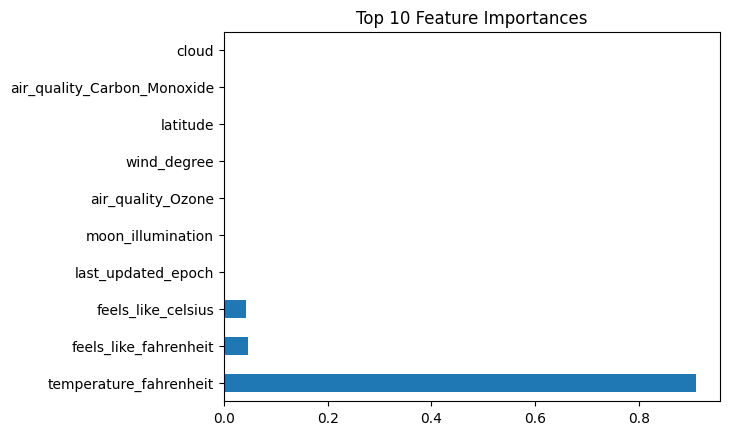

In [23]:
# Choose target and features
features = [col for col in num_cols if col != 'temperature_celsius']
target = 'temperature_celsius'

# Random Forest
rf = RandomForestRegressor()
rf.fit(df[features], df[target])

importances = pd.Series(rf.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()


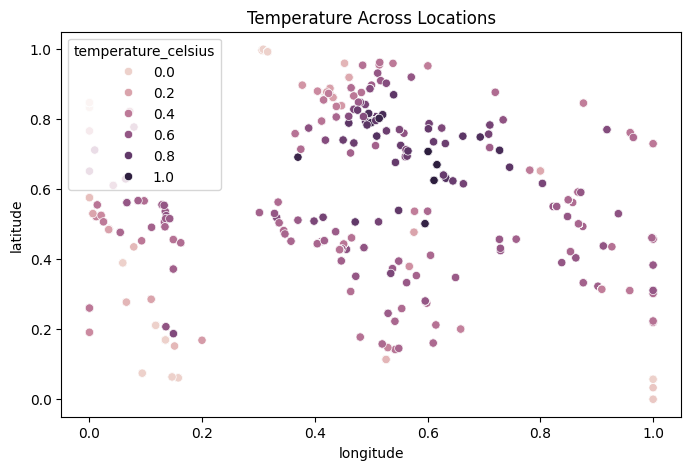

In [24]:
# If you have latitude, longitude features
plt.figure(figsize=(8,5))
sns.scatterplot(x='longitude', y='latitude', hue='temperature_celsius', data=df)
plt.title('Temperature Across Locations')
plt.show()
